<a href="https://colab.research.google.com/github/amimulhasan/Deep-Learning/blob/main/92_acc_brain_tumor_mri_classification_vgg16_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook objectives
- Use Xception to classify brain tumors

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download tombackert/brain-tumor-mri-data

Dataset URL: https://www.kaggle.com/datasets/tombackert/brain-tumor-mri-data
License(s): MIT
 84% 127M/151M [00:00<00:00, 1.33GB/s]
100% 151M/151M [00:00<00:00, 1.24GB/s]


In [ ]:
import zipfile

zip_path = '/content/brain-tumor-mri-data.zip'
extract_to = 'Tumor_brain_cancer'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Unzipping completed!")

Unzipping completed!


In [ ]:
### Imports

import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob


#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


#---------------------------------------
import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers import SGD
#---------------------------------------


import warnings
warnings.filterwarnings("ignore")


# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

# Explanatory Data Analysis (EDA)

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not founde')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
def load_df(path):
    classes, class_paths = zip(*[(label, os.path.join(path, label, image))
                                 for label in os.listdir(path) if os.path.isdir(os.path.join(path, label))
                                 for image in os.listdir(os.path.join(path, label))])

    df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return df

In [ ]:
df = load_df('/content/Tumor_brain_cancer/brain-tumor-mri-dataset')

In [ ]:
df

,Class Path,Class
0,/content/Tumor_brain_cancer/brain-tumor-mri-da...,glioma
1,/content/Tumor_brain_cancer/brain-tumor-mri-da...,glioma
2,/content/Tumor_brain_cancer/brain-tumor-mri-da...,glioma
3,/content/Tumor_brain_cancer/brain-tumor-mri-da...,glioma
4,/content/Tumor_brain_cancer/brain-tumor-mri-da...,glioma
...,...,...
7148,/content/Tumor_brain_cancer/brain-tumor-mri-da...,meningioma
7149,/content/Tumor_brain_cancer/brain-tumor-mri-da...,meningioma
7150,/content/Tumor_brain_cancer/brain-tumor-mri-da...,meningioma
7151,/content/Tumor_brain_cancer/brain-tumor-mri-da...,meningioma


In [ ]:
### Function for counting images in each class
def count_images(df):
  plt.figure(figsize=(15,7))
  ax = sns.countplot(data=df, y=df['Class'], palette='rocket')

  plt.xlabel('')
  plt.ylabel('')
  plt.title('Count of images in each class')
  ax.bar_label(ax.containers[0])
  plt.show()

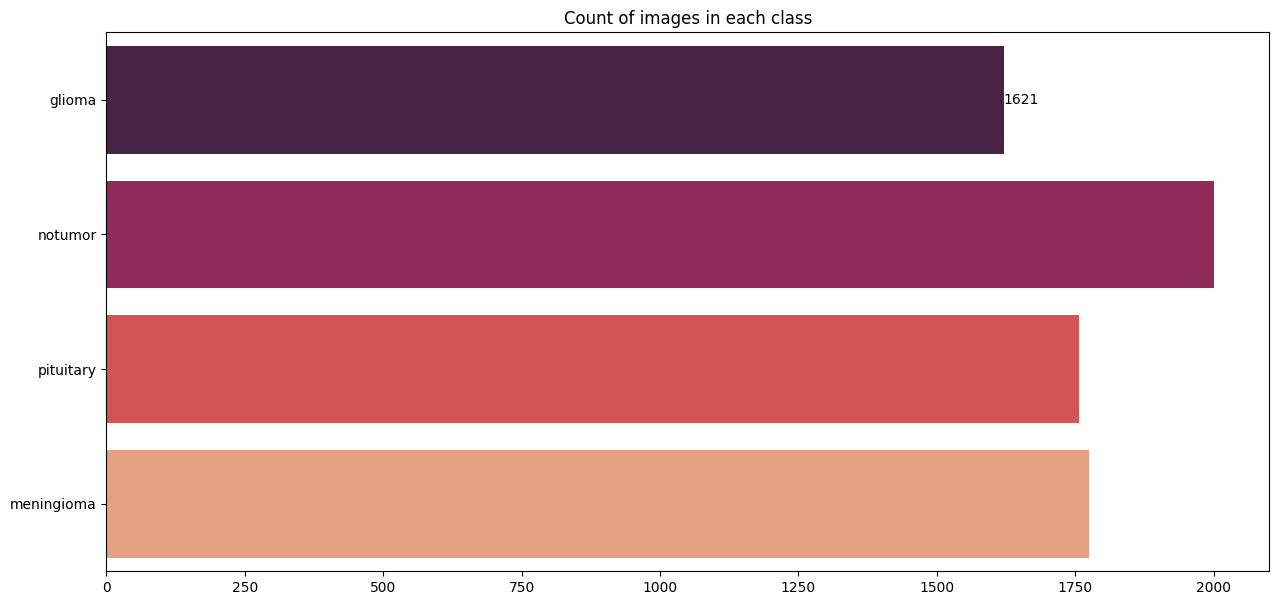

In [ ]:
count_images(df)

In [ ]:
# Train: 81.7%, Validation: 9.1%, Test: 9.2%

train_df, test_val_df = train_test_split(df, train_size=5842 / 7153, random_state=42, stratify=df['Class'])

valid_df, test_df = train_test_split(test_val_df, train_size=655 / len(test_val_df), random_state=20, stratify=test_val_df['Class'])

print(f"Train size: {len(train_df)} rows")
print(f"Validation size: {len(valid_df)} rows")
print(f"Test size: {len(test_df)} rows")

Train size: 5842 rows
Validation size: 655 rows
Test size: 656 rows


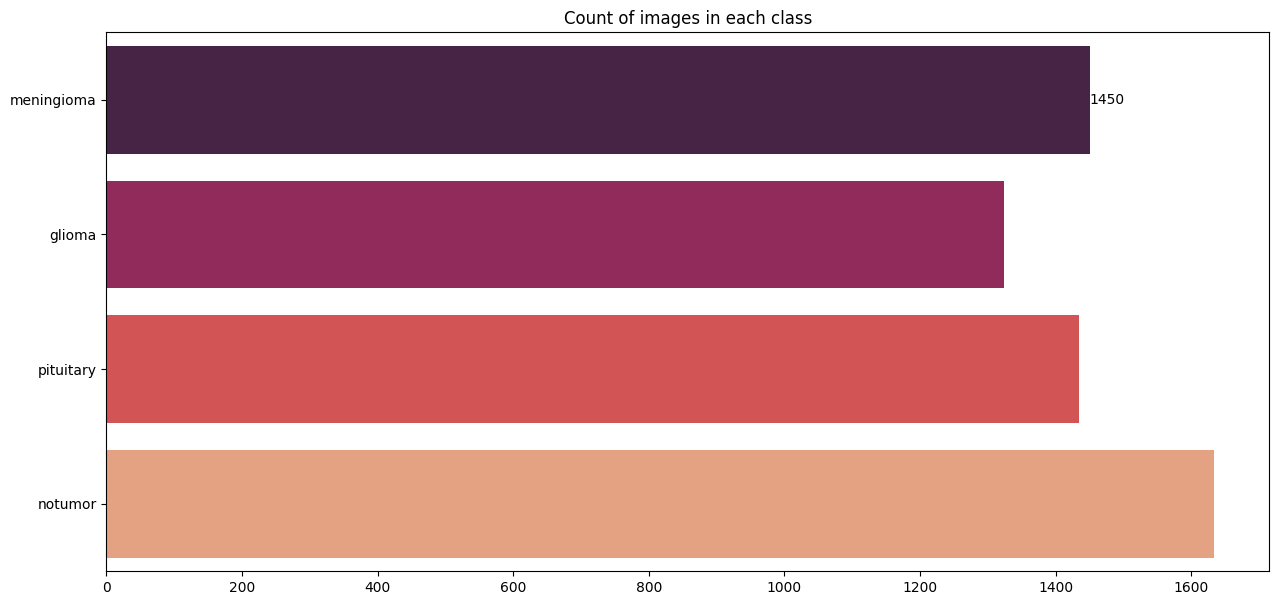

In [ ]:
count_images(train_df)

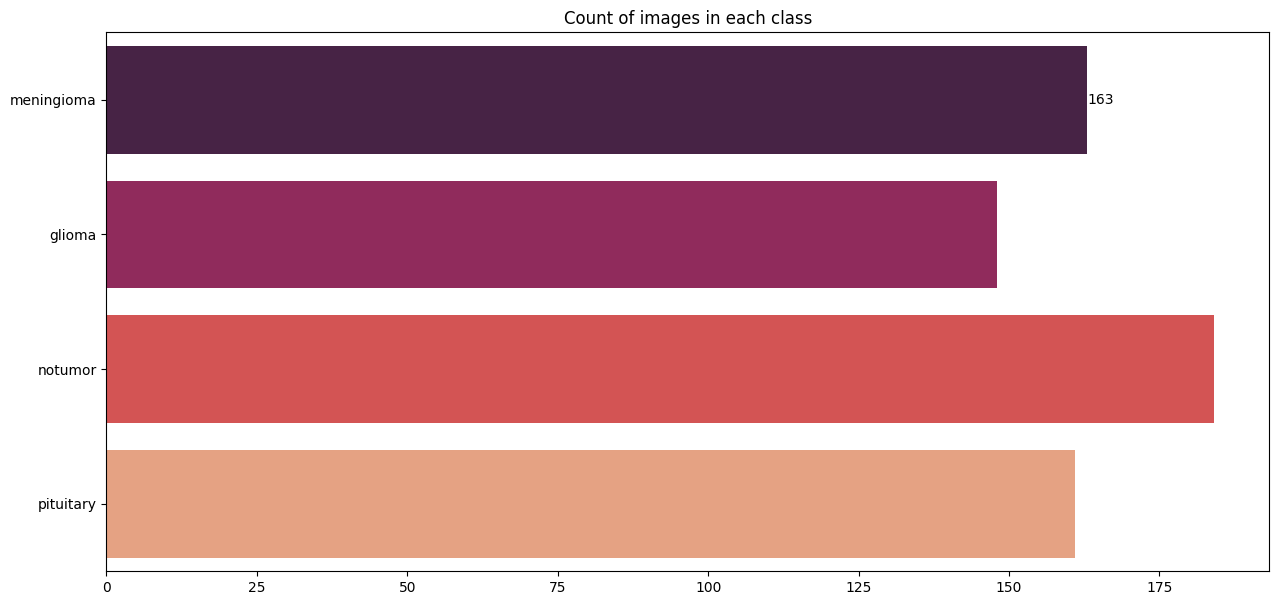

In [ ]:
count_images(test_df)

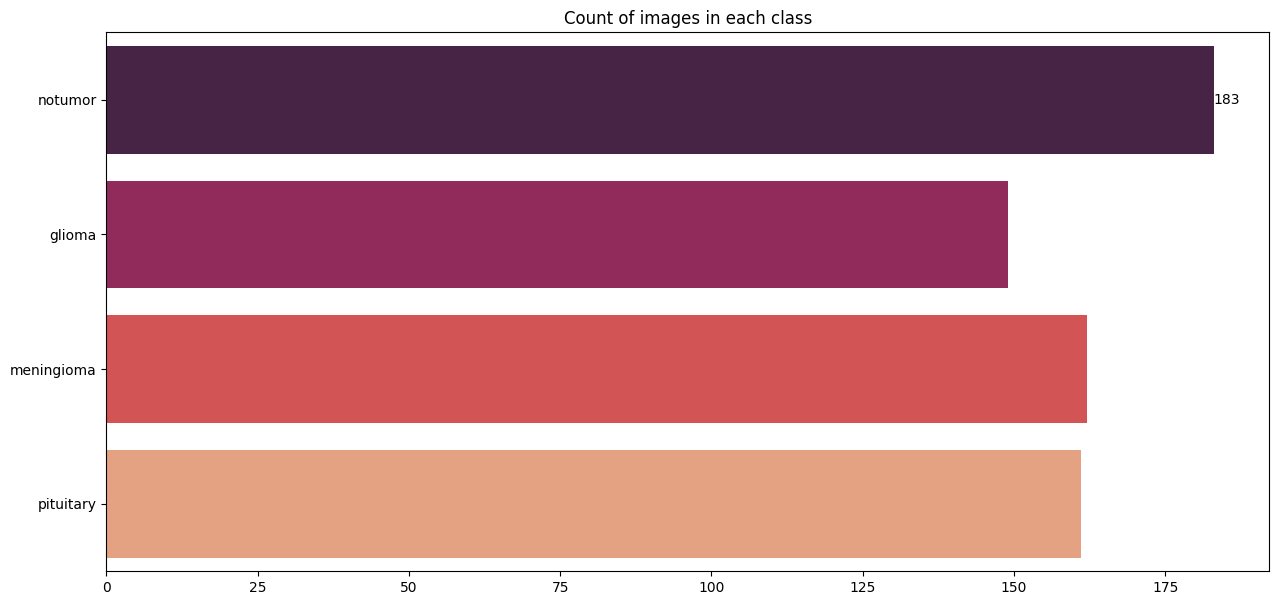

In [ ]:
count_images(valid_df)

# Data Preprocessing

In [ ]:
batch_size = 32
img_size = (224, 224)

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    brightness_range=(0.8, 1.2)
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=batch_size,
    target_size=img_size
)

valid_gen = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=batch_size,
    target_size=img_size
)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=16,
    target_size=img_size,
    shuffle=False
)

Found 5842 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


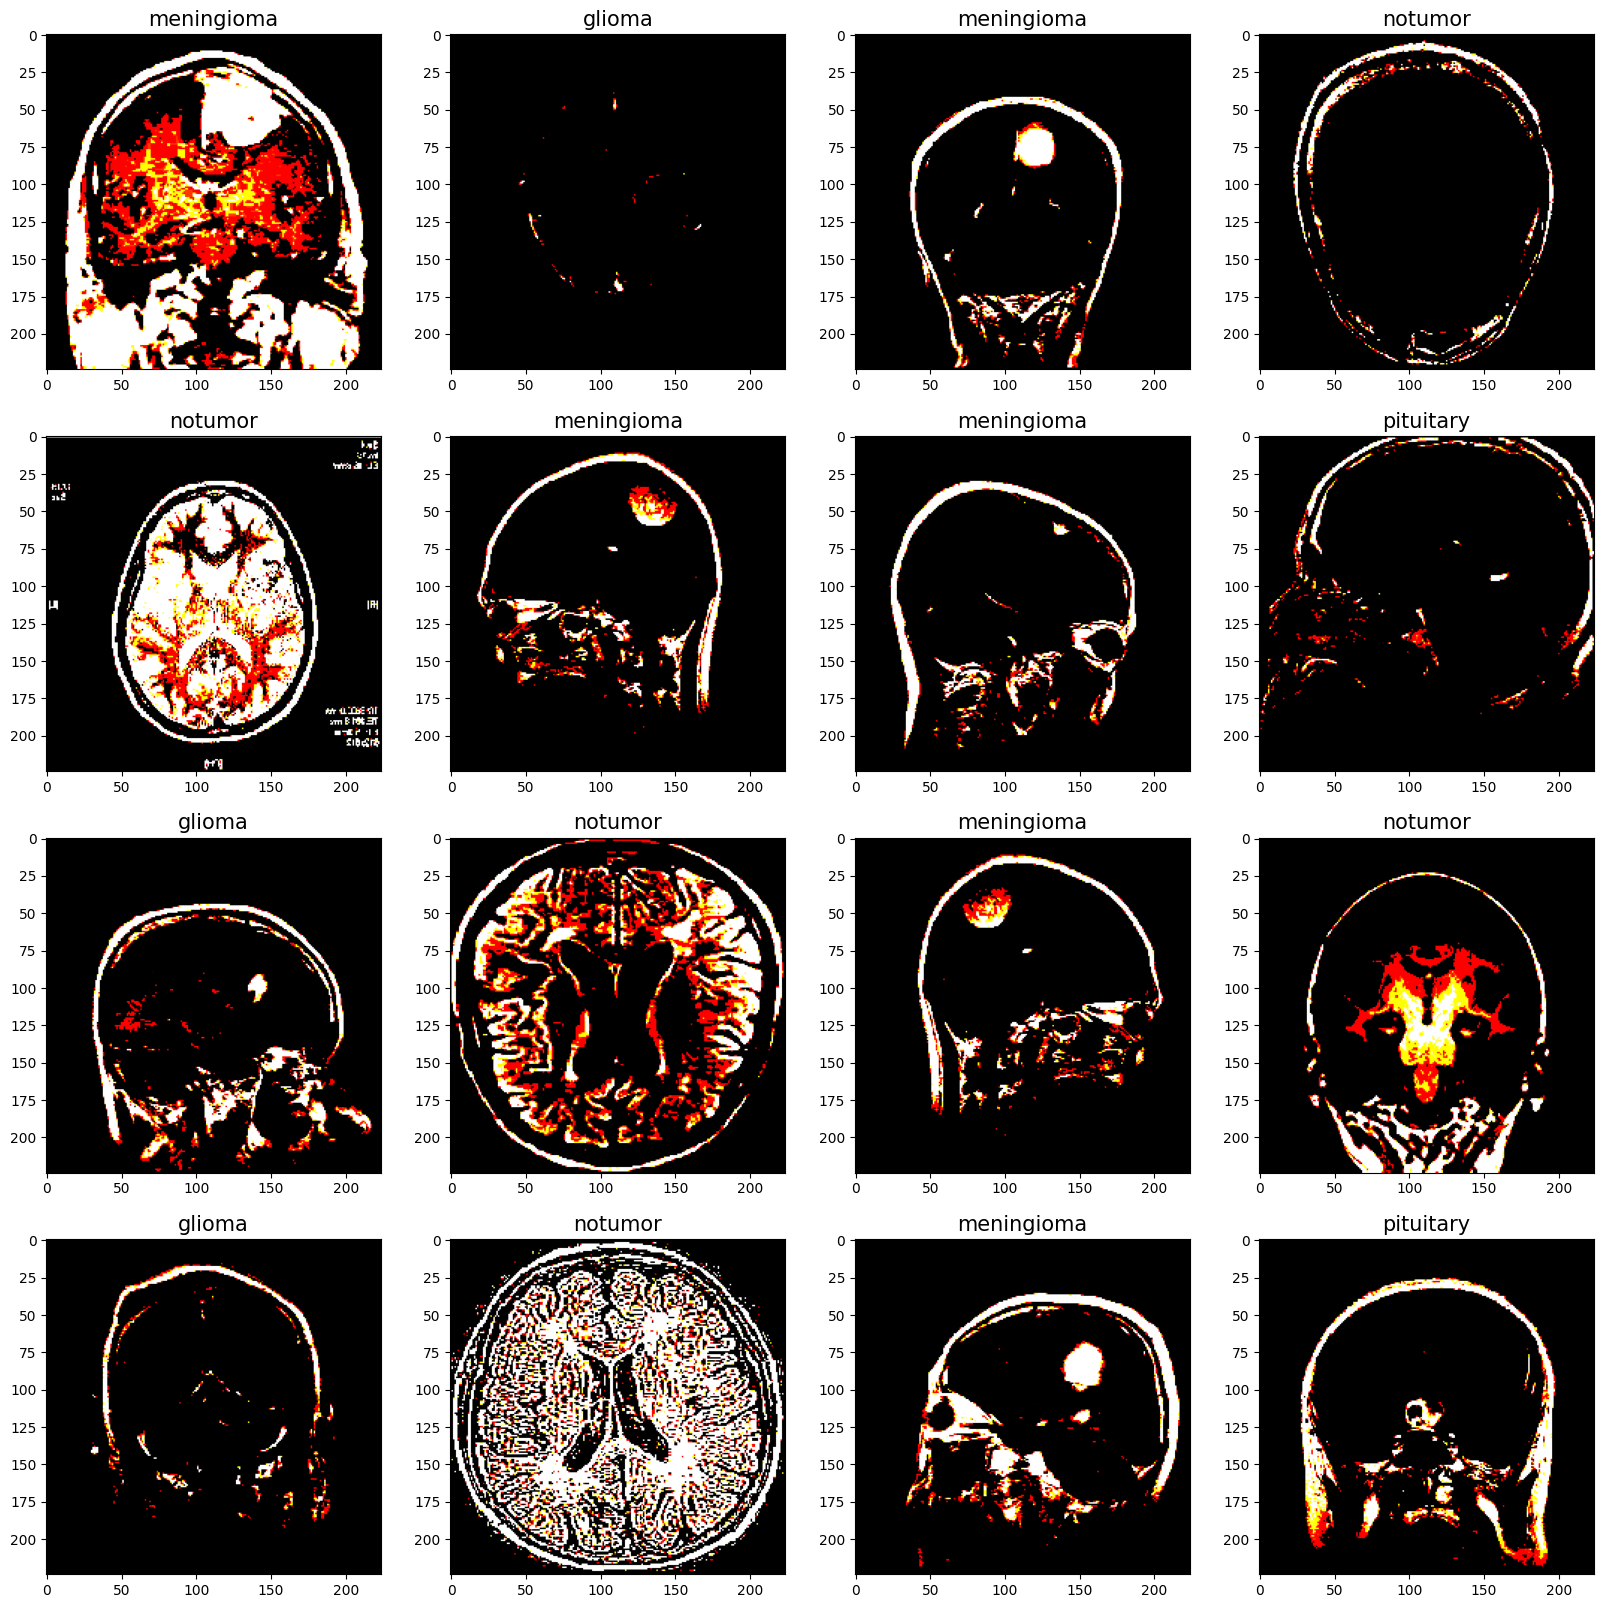

In [ ]:
class_dict = train_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(test_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

# Model Building

In [ ]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling='max'
)

# froze all layers
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])



80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# base_model.summary()

# Model Training

In [ ]:
### Training Loop on GPU

with tf.device(device_name):
    # Training of top layer
    hist = model.fit(train_gen, validation_data=valid_gen, epochs=5)

Epoch 1/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 72s 315ms/step - accuracy: 0.4523 - loss: 14.8989 - precision: 0.4527 - recall: 0.4522 - val_accuracy: 0.6916 - val_loss: 1.3414 - val_precision: 0.6975 - val_recall: 0.6794
Epoch 2/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 41s 221ms/step - accuracy: 0.5852 - loss: 3.4453 - precision: 0.5885 - recall: 0.5813 - val_accuracy: 0.7023 - val_loss: 0.7706 - val_precision: 0.7883 - val_recall: 0.5740
Epoch 3/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 40s 220ms/step - accuracy: 0.5781 - loss: 1.6997 - precision: 0.6087 - recall: 0.5454 - val_accuracy: 0.6641 - val_loss: 0.8803 - val_precision: 0.8702 - val_recall: 0.3786
Epoch 4/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 41s 221ms/step - accuracy: 0.5928 - loss: 1.2482 - precision: 0.6596 - recall: 0.5019 - val_accuracy: 0.6763 - val_loss: 0.8455 - val_precision: 0.8968 - val_recall: 0.3847
Epoch 5/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 40s 221ms/step - accuracy: 0.6213 - loss: 1.0320 - precision: 0.7088 - recall: 0.5064 - val_accuracy: 0.7023 - v

In [ ]:
import time
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall

# "Defroze" some convolutional blocks
# Defroze last block of VGG16
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adamax(learning_rate=1e-4),  # lower LR for Fine-Tuning
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Start the timer to record the total training time
start_time = time.time()

# Train the model within the specified device (if using specific device)
with tf.device(device_name):
    hist2 = model.fit(train_gen, validation_data=valid_gen, epochs=5)

# Calculate total training time
end_time = time.time()
training_time = end_time - start_time

# Print the total training time in seconds and formatted to minutes
print(f"Total Training Time: {training_time:.2f} seconds")
print(f"Total Training Time: {training_time / 60:.2f} minutes")


Epoch 1/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 57s 275ms/step - accuracy: 0.6718 - loss: 0.8805 - precision_1: 0.7429 - recall_1: 0.5872 - val_accuracy: 0.8290 - val_loss: 0.4239 - val_precision_1: 0.8806 - val_recall_1: 0.7542
Epoch 2/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 44s 242ms/step - accuracy: 0.7961 - loss: 0.5531 - precision_1: 0.8303 - recall_1: 0.7471 - val_accuracy: 0.8702 - val_loss: 0.3278 - val_precision_1: 0.8995 - val_recall_1: 0.8336
Epoch 3/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 44s 241ms/step - accuracy: 0.8413 - loss: 0.4238 - precision_1: 0.8663 - recall_1: 0.8151 - val_accuracy: 0.9084 - val_loss: 0.2541 - val_precision_1: 0.9311 - val_recall_1: 0.8870
Epoch 4/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 44s 241ms/step - accuracy: 0.8708 - loss: 0.3537 - precision_1: 0.8868 - recall_1: 0.8525 - val_accuracy: 0.9344 - val_loss: 0.2010 - val_precision_1: 0.9437 - val_recall_1: 0.9206
Epoch 5/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 44s 241ms/step - accuracy: 0.8856 - loss: 0.3029 - precision_1: 0.9008 - recall_1

In [ ]:
# # "defroze" some convolutional blocks
# # defroze last block of VGG16
# for layer in base_model.layers[-4:]:
#     layer.trainable = True

# model.compile(optimizer=Adamax(learning_rate=1e-4),  # lower LR for Fine-Tuning
#               loss='categorical_crossentropy',
#               metrics=['accuracy', Precision(), Recall()])

# with tf.device(device_name):
#     hist2 = model.fit(train_gen, validation_data=valid_gen, epochs=5)

# Model Testing

In [ ]:
hist = hist2

# Hist first phase

In [ ]:
# #tr_acc = hist.history['accuracy']
# #tr_loss = hist.history['loss']
# #tr_per = hist.history['precision_1']
# #tr_recall = hist.history['recall_1']
# #val_acc = hist.history['val_accuracy_1']
# #val_loss = hist.history['val_loss_1']
# #val_per = hist.history['val_precision_1']
# #val_recall = hist.history['val_recall_1']

# ####
# tr_acc = hist.history['accuracy']
# tr_loss = hist.history['loss']
# tr_per = hist.history['precision_1']
# tr_recall = hist.history['recall_1']
# val_acc = hist.history['val_accuracy']
# val_loss = hist.history['val_loss']
# val_per = hist.history['val_precision_1']
# val_recall = hist.history['val_recall_1']
# ####

# index_loss = np.argmin(val_loss)
# val_lowest = val_loss[index_loss]
# index_acc = np.argmax(val_acc)
# acc_highest = val_acc[index_acc]
# index_precision = np.argmax(val_per)
# per_highest = val_per[index_precision]
# index_recall = np.argmax(val_recall)
# recall_highest = val_recall[index_recall]

# Epochs = [i + 1 for i in range(len(tr_acc))]
# loss_label = f'Best epoch = {str(index_loss + 1)}'
# acc_label = f'Best epoch = {str(index_acc + 1)}'
# per_label = f'Best epoch = {str(index_precision + 1)}'
# recall_label = f'Best epoch = {str(index_recall + 1)}'


# plt.figure(figsize=(20, 12))
# plt.style.use('fivethirtyeight')
# plt.subplot(2, 2, 1)
# plt.plot(Epochs, tr_loss, 'r', label='Training loss')
# plt.plot(Epochs, val_loss, 'g', label='Validation loss')
# plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid(True)

# plt.subplot(2, 2, 2)
# plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
# plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
# plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid(True)

# plt.subplot(2, 2, 3)
# plt.plot(Epochs, tr_per, 'r', label='Precision')
# plt.plot(Epochs, val_per, 'g', label='Validation Precision')
# plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
# plt.title('Precision and Validation Precision')
# plt.xlabel('Epochs')
# plt.ylabel('Precision')
# plt.legend()
# plt.grid(True)

# plt.subplot(2, 2, 4)
# plt.plot(Epochs, tr_recall, 'r', label='Recall')
# plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
# plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
# plt.title('Recall and Validation Recall')
# plt.xlabel('Epochs')
# plt.ylabel('Recall')
# plt.legend()
# plt.grid(True)

# plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
# plt.show()

In [ ]:
train_gen_copy = train_gen
valid_gen_copy = valid_gen
test_gen_copy = test_gen

In [ ]:
#add
from sklearn.metrics import classification_report
import numpy as np

# Evaluate model
train_score = model.evaluate(train_gen_copy, verbose=1)
valid_score = model.evaluate(valid_gen_copy, verbose=1)
test_score = model.evaluate(test_gen_copy, verbose=1)

# Predict on the datasets to calculate F1 score
train_pred = model.predict(train_gen_copy, verbose=1)
valid_pred = model.predict(valid_gen_copy, verbose=1)
test_pred = model.predict(test_gen_copy, verbose=1)

# Convert predictions to binary (for binary classification) or classes for multi-class
train_pred_classes = np.argmax(train_pred, axis=1)
valid_pred_classes = np.argmax(valid_pred, axis=1)
test_pred_classes = np.argmax(test_pred, axis=1)

# Assuming your dataset has labels in a format like one-hot encoded or integer encoded
train_labels = train_gen_copy.classes
valid_labels = valid_gen_copy.classes
test_labels = test_gen_copy.classes

# F1 score calculation using classification report
train_f1 = classification_report(train_labels, train_pred_classes, output_dict=True)['weighted avg']['f1-score']
valid_f1 = classification_report(valid_labels, valid_pred_classes, output_dict=True)['weighted avg']['f1-score']
test_f1 = classification_report(test_labels, test_pred_classes, output_dict=True)['weighted avg']['f1-score']

# Print scores
print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print(f"Train F1 Score: {train_f1:.4f}")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print(f"Validation F1 Score: {valid_f1:.4f}")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")
print(f"Test F1 Score: {test_f1:.4f}")
#Adamax

183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 203ms/step - accuracy: 0.9561 - loss: 0.1242 - precision_1: 0.9630 - recall_1: 0.9472
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.9251 - loss: 0.2431 - precision_1: 0.9245 - recall_1: 0.9057
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.9355 - loss: 0.2219 - precision_1: 0.9457 - recall_1: 0.9120
183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 205ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 224ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step
Train Loss: 0.1266
Train Accuracy: 95.43%
Train F1 Score: 0.2523
--------------------
Validation Loss: 0.1854
Validation Accuracy: 93.59%
Validation F1 Score: 0.2372
--------------------
Test Loss: 0.2198
Test Accuracy: 92.23%
Test F1 Score: 0.9213


In [ ]:
#add

In [ ]:
### Training Loop on GPU

# with tf.device(device_name):
#     # Training of top layer
#     hist = model.fit(train_gen, validation_data=valid_gen, epochs=5)

In [ ]:

from tensorflow.keras.optimizers import SGD

In [ ]:
import time
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import Precision, Recall

# "Defroze" some convolutional blocks
# Defroze last block of VGG16
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=SGD(learning_rate=1e-4),  # lower LR for Fine-Tuning
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Start the timer to record the total training time
start_time = time.time()

# Train the model within the specified device (if using specific device)
with tf.device(device_name):
    hist2 = model.fit(train_gen, validation_data=valid_gen, epochs=5)

# Calculate total training time
end_time = time.time()
training_time = end_time - start_time

# Print the total training time in seconds and formatted to minutes
print(f"Total Training Time: {training_time:.2f} seconds")
print(f"Total Training Time: {training_time / 60:.2f} minutes")


Epoch 1/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 51s 258ms/step - accuracy: 0.9024 - loss: 0.2602 - precision_2: 0.9118 - recall_2: 0.8924 - val_accuracy: 0.9405 - val_loss: 0.1743 - val_precision_2: 0.9472 - val_recall_2: 0.9313
Epoch 2/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 44s 238ms/step - accuracy: 0.9047 - loss: 0.2725 - precision_2: 0.9127 - recall_2: 0.8922 - val_accuracy: 0.9466 - val_loss: 0.1668 - val_precision_2: 0.9534 - val_recall_2: 0.9374
Epoch 3/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 44s 237ms/step - accuracy: 0.9076 - loss: 0.2418 - precision_2: 0.9161 - recall_2: 0.8965 - val_accuracy: 0.9496 - val_loss: 0.1632 - val_precision_2: 0.9521 - val_recall_2: 0.9405
Epoch 4/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 44s 237ms/step - accuracy: 0.9117 - loss: 0.2407 - precision_2: 0.9197 - recall_2: 0.9031 - val_accuracy: 0.9481 - val_loss: 0.1647 - val_precision_2: 0.9508 - val_recall_2: 0.9435
Epoch 5/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 44s 238ms/step - accuracy: 0.9131 - loss: 0.2314 - precision_2: 0.9234 - recall_2

In [ ]:
hist = hist2

In [ ]:
train_gen_copy = train_gen
valid_gen_copy = valid_gen
test_gen_copy = test_gen

In [ ]:
#add
from sklearn.metrics import classification_report
import numpy as np

# Evaluate model
train_score = model.evaluate(train_gen_copy, verbose=1)
valid_score = model.evaluate(valid_gen_copy, verbose=1)
test_score = model.evaluate(test_gen_copy, verbose=1)

# Predict on the datasets to calculate F1 score
train_pred = model.predict(train_gen_copy, verbose=1)
valid_pred = model.predict(valid_gen_copy, verbose=1)
test_pred = model.predict(test_gen_copy, verbose=1)

# Convert predictions to binary (for binary classification) or classes for multi-class
train_pred_classes = np.argmax(train_pred, axis=1)
valid_pred_classes = np.argmax(valid_pred, axis=1)
test_pred_classes = np.argmax(test_pred, axis=1)

# Assuming your dataset has labels in a format like one-hot encoded or integer encoded
train_labels = train_gen_copy.classes
valid_labels = valid_gen_copy.classes
test_labels = test_gen_copy.classes

# F1 score calculation using classification report
train_f1 = classification_report(train_labels, train_pred_classes, output_dict=True)['weighted avg']['f1-score']
valid_f1 = classification_report(valid_labels, valid_pred_classes, output_dict=True)['weighted avg']['f1-score']
test_f1 = classification_report(test_labels, test_pred_classes, output_dict=True)['weighted avg']['f1-score']

# Print scores
print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print(f"Train F1 Score: {train_f1:.4f}")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print(f"Validation F1 Score: {valid_f1:.4f}")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")
print(f"Test F1 Score: {test_f1:.4f}")

# SGD

183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 203ms/step - accuracy: 0.9641 - loss: 0.1060 - precision_2: 0.9693 - recall_2: 0.9577
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - accuracy: 0.9559 - loss: 0.1365 - precision_2: 0.9595 - recall_2: 0.9436
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.9372 - loss: 0.2075 - precision_2: 0.9484 - recall_2: 0.9217
183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 201ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step
Train Loss: 0.1030
Train Accuracy: 96.58%
Train F1 Score: 0.2463
--------------------
Validation Loss: 0.1620
Validation Accuracy: 94.66%
Validation F1 Score: 0.2643
--------------------
Test Loss: 0.2088
Test Accuracy: 92.53%
Test F1 Score: 0.9253


In [ ]:
from tensorflow.keras.optimizers import AdamW

In [ ]:
hist = hist2

In [ ]:
train_gen_copy = train_gen
valid_gen_copy = valid_gen
test_gen_copy = test_gen

In [ ]:
import time
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.metrics import Precision, Recall

# "Defroze" some convolutional blocks
# Defroze last block of VGG16
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=AdamW(learning_rate=1e-4),  # lower LR for Fine-Tuning
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Start the timer to record the total training time
start_time = time.time()

# Train the model within the specified device (if using specific device)
with tf.device(device_name):
    hist2 = model.fit(train_gen, validation_data=valid_gen, epochs=5)

# Calculate total training time
end_time = time.time()
training_time = end_time - start_time

# Print the total training time in seconds and formatted to minutes
print(f"Total Training Time: {training_time:.2f} seconds")
print(f"Total Training Time: {training_time / 60:.2f} minutes")


Epoch 1/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 53s 265ms/step - accuracy: 0.8549 - loss: 0.4224 - precision_3: 0.8686 - recall_3: 0.8402 - val_accuracy: 0.9252 - val_loss: 0.2083 - val_precision_3: 0.9490 - val_recall_3: 0.9084
Epoch 2/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 44s 242ms/step - accuracy: 0.8747 - loss: 0.3291 - precision_3: 0.8967 - recall_3: 0.8574 - val_accuracy: 0.9420 - val_loss: 0.1786 - val_precision_3: 0.9487 - val_recall_3: 0.9313
Epoch 3/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 44s 241ms/step - accuracy: 0.8936 - loss: 0.3012 - precision_3: 0.9082 - recall_3: 0.8817 - val_accuracy: 0.9282 - val_loss: 0.1696 - val_precision_3: 0.9410 - val_recall_3: 0.9252
Epoch 4/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 84s 251ms/step - accuracy: 0.9283 - loss: 0.2184 - precision_3: 0.9366 - recall_3: 0.9189 - val_accuracy: 0.9573 - val_loss: 0.1121 - val_precision_3: 0.9585 - val_recall_3: 0.9511
Epoch 5/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 44s 242ms/step - accuracy: 0.9474 - loss: 0.1575 - precision_3: 0.9510 - recall_3

In [ ]:
#add
from sklearn.metrics import classification_report
import numpy as np

# Evaluate model
train_score = model.evaluate(train_gen_copy, verbose=1)
valid_score = model.evaluate(valid_gen_copy, verbose=1)
test_score = model.evaluate(test_gen_copy, verbose=1)

# Predict on the datasets to calculate F1 score
train_pred = model.predict(train_gen_copy, verbose=1)
valid_pred = model.predict(valid_gen_copy, verbose=1)
test_pred = model.predict(test_gen_copy, verbose=1)

# Convert predictions to binary (for binary classification) or classes for multi-class
train_pred_classes = np.argmax(train_pred, axis=1)
valid_pred_classes = np.argmax(valid_pred, axis=1)
test_pred_classes = np.argmax(test_pred, axis=1)

# Assuming your dataset has labels in a format like one-hot encoded or integer encoded
train_labels = train_gen_copy.classes
valid_labels = valid_gen_copy.classes
test_labels = test_gen_copy.classes

# F1 score calculation using classification report
train_f1 = classification_report(train_labels, train_pred_classes, output_dict=True)['weighted avg']['f1-score']
valid_f1 = classification_report(valid_labels, valid_pred_classes, output_dict=True)['weighted avg']['f1-score']
test_f1 = classification_report(test_labels, test_pred_classes, output_dict=True)['weighted avg']['f1-score']

# Print scores
print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print(f"Train F1 Score: {train_f1:.4f}")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print(f"Validation F1 Score: {valid_f1:.4f}")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")
print(f"Test F1 Score: {test_f1:.4f}")

# adamw

183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 202ms/step - accuracy: 0.9849 - loss: 0.0463 - precision_3: 0.9859 - recall_3: 0.9841
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - accuracy: 0.9603 - loss: 0.1254 - precision_3: 0.9620 - recall_3: 0.9603
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.9517 - loss: 0.1063 - precision_3: 0.9620 - recall_3: 0.9501
183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 204ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step
Train Loss: 0.0486
Train Accuracy: 98.34%
Train F1 Score: 0.2566
--------------------
Validation Loss: 0.1125
Validation Accuracy: 96.34%
Validation F1 Score: 0.2712
--------------------
Test Loss: 0.1166
Test Accuracy: 95.12%
Test F1 Score: 0.9509


In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
import time
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

# "Defroze" some convolutional blocks
# Defroze last block of VGG16
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-4),  # lower LR for Fine-Tuning
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Start the timer to record the total training time
start_time = time.time()

# Train the model within the specified device (if using specific device)
with tf.device(device_name):
    hist2 = model.fit(train_gen, validation_data=valid_gen, epochs=5)

# Calculate total training time
end_time = time.time()
training_time = end_time - start_time

# Print the total training time in seconds and formatted to minutes
print(f"Total Training Time: {training_time:.2f} seconds")
print(f"Total Training Time: {training_time / 60:.2f} minutes")


Epoch 1/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 53s 264ms/step - accuracy: 0.9408 - loss: 0.1602 - precision_4: 0.9450 - recall_4: 0.9368 - val_accuracy: 0.9725 - val_loss: 0.0914 - val_precision_4: 0.9725 - val_recall_4: 0.9725
Epoch 2/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 44s 239ms/step - accuracy: 0.9488 - loss: 0.1558 - precision_4: 0.9517 - recall_4: 0.9463 - val_accuracy: 0.9725 - val_loss: 0.0814 - val_precision_4: 0.9725 - val_recall_4: 0.9725
Epoch 3/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 44s 239ms/step - accuracy: 0.9511 - loss: 0.1417 - precision_4: 0.9551 - recall_4: 0.9484 - val_accuracy: 0.9740 - val_loss: 0.0993 - val_precision_4: 0.9755 - val_recall_4: 0.9740
Epoch 4/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 44s 240ms/step - accuracy: 0.9633 - loss: 0.1028 - precision_4: 0.9663 - recall_4: 0.9604 - val_accuracy: 0.9832 - val_loss: 0.0553 - val_precision_4: 0.9847 - val_recall_4: 0.9817
Epoch 5/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 45s 245ms/step - accuracy: 0.9750 - loss: 0.0669 - precision_4: 0.9764 - recall_4

In [ ]:
hist = hist2

In [ ]:
train_gen_copy = train_gen
valid_gen_copy = valid_gen
test_gen_copy = test_gen

In [ ]:
#add
from sklearn.metrics import classification_report
import numpy as np

# Evaluate model
train_score = model.evaluate(train_gen_copy, verbose=1)
valid_score = model.evaluate(valid_gen_copy, verbose=1)
test_score = model.evaluate(test_gen_copy, verbose=1)

# Predict on the datasets to calculate F1 score
train_pred = model.predict(train_gen_copy, verbose=1)
valid_pred = model.predict(valid_gen_copy, verbose=1)
test_pred = model.predict(test_gen_copy, verbose=1)

# Convert predictions to binary (for binary classification) or classes for multi-class
train_pred_classes = np.argmax(train_pred, axis=1)
valid_pred_classes = np.argmax(valid_pred, axis=1)
test_pred_classes = np.argmax(test_pred, axis=1)

# Assuming your dataset has labels in a format like one-hot encoded or integer encoded
train_labels = train_gen_copy.classes
valid_labels = valid_gen_copy.classes
test_labels = test_gen_copy.classes

# F1 score calculation using classification report
train_f1 = classification_report(train_labels, train_pred_classes, output_dict=True)['weighted avg']['f1-score']
valid_f1 = classification_report(valid_labels, valid_pred_classes, output_dict=True)['weighted avg']['f1-score']
test_f1 = classification_report(test_labels, test_pred_classes, output_dict=True)['weighted avg']['f1-score']

# Print scores
print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print(f"Train F1 Score: {train_f1:.4f}")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print(f"Validation F1 Score: {valid_f1:.4f}")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")
print(f"Test F1 Score: {test_f1:.4f}")
# adam

183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 203ms/step - accuracy: 0.9936 - loss: 0.0190 - precision_4: 0.9936 - recall_4: 0.9936
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 198ms/step - accuracy: 0.9772 - loss: 0.0690 - precision_4: 0.9772 - recall_4: 0.9772
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9652 - loss: 0.0804 - precision_4: 0.9669 - recall_4: 0.9652
183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 202ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 221ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step
Train Loss: 0.0212
Train Accuracy: 99.30%
Train F1 Score: 0.2543
--------------------
Validation Loss: 0.0683
Validation Accuracy: 98.02%
Validation F1 Score: 0.2672
--------------------
Test Loss: 0.0891
Test Accuracy: 96.34%
Test F1 Score: 0.9634


In [ ]:
#end...

In [ ]:
# train_score = model.evaluate(train_gen_copy, verbose=1)
# valid_score = model.evaluate(valid_gen_copy, verbose=1)
# test_score = model.evaluate(test_gen_copy, verbose=1)

# print(f"Train Loss: {train_score[0]:.4f}")
# print(f"Train Accuracy: {train_score[1]*100:.2f}%")
# print('-' * 20)
# print(f"Validation Loss: {valid_score[0]:.4f}")
# print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
# print('-' * 20)
# print(f"Test Loss: {test_score[0]:.4f}")
# print(f"Test Accuracy: {test_score[1]*100:.2f}%")

In [ ]:
# ResNet101
preds = model.predict(test_gen_copy)
y_pred = np.argmax(preds, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step


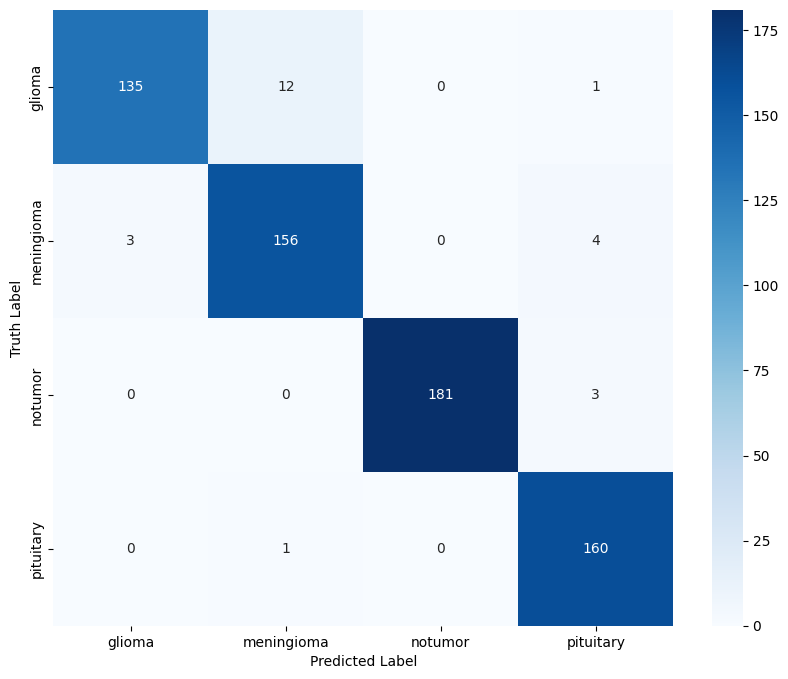

In [ ]:
### Confusion Matrix

cm = confusion_matrix(test_gen_copy.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [ ]:
### Functin for getting predictions

def predict(img_path):
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()